In [1]:
#Import Libraries
import pandas as pd
import numpy as np

#For EDA (Location Visualizations)
import folium
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('seaborn')
import seaborn as sns


#Preprocessing & Imputation
from sklearn.impute import KNNImputer
from sklearn import preprocessing
import ast #For converting string to list

#Feature Engineering
from geopy.distance import great_circle
from collections import Counter

#Data Management
import joblib

#Jupyter-Notebook Related
pd.options.mode.chained_assignment = None  
pd.set_option('display.max_columns',80)  # or 1000
pd.set_option('display.max_rows', 100)  # or 1000

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Import dataset
df_raw = pd.read_csv('data/listings.csv')

#Checking Shape
print(f'{df_raw.shape[0]} examples, {df_raw.shape[1]} features')

# ... and duplicates
print("It contains {} duplicates.".format(df_raw.duplicated().sum()))


24551 examples, 106 features
It contains 0 duplicates.


In [3]:
# Deciding which columns to work with

#1 City, street, state are mostly same for all, id is unique and scrape_id is same for all.
#2 experiences_offered, thumbnail_url, medium_url are  empty
#3 picture_url, host_thumbnail_url, host_picture_url links are broken.

columns_to_discard = ['city','scrape_id','experiences_offered','thumbnail_url','medium_url',
                     'picture_url','xl_picture_url','host_acceptance_rate','host_thumbnail_url',
                     'host_picture_url','street','state','market','smart_location','country_code',
                     'country','has_availability','calendar_last_scraped','license','jurisdiction_names',
                     'is_business_travel_ready','host_name','square_feet',
                     'calendar_updated','host_id','zipcode']

#Columns with working link: Can be used for data scraping
linked_columns= ['listing_url','host_url']

#Columns that can be analyzed with NLP
text_columns = ['name','summary','description','neighborhood_overview',
               'notes','transit','access','interaction','house_rules','host_about']

#Date columns can be feature-engineered
date_columns = ['host_since','first_review','last_review',]

#Categorical columns (will be converted to categories)
cat_columns = ['last_scraped','host_response_time','host_response_rate','host_is_superhost',
              'host_neighbourhood','host_verifications','host_has_profile_pic','host_identity_verified',
              'neighbourhood','neighbourhood_cleansed','neighbourhood_group_cleansed','is_location_exact',
              'property_type','room_type','bed_type','amenities','calendar_updated','requires_license',
              'instant_bookable','cancellation_policy','require_guest_profile_picture',
               'require_guest_phone_verification']

target_column = 'price'

print(len(df_raw.columns),'total column count')
print('----------------------------------')
print(len(columns_to_discard), 'useless columns')
print(len(linked_columns),'columns with link included')
print(len(text_columns),'text columns')
print(len(date_columns),'date type columns')
print(len(cat_columns),'categorical columns')


106 total column count
----------------------------------
26 useless columns
2 columns with link included
10 text columns
3 date type columns
22 categorical columns


### Notes:

* Interesting feature is text german or english
* Didn't understand host_listings_count and host_total_listings_count (will look more closely)
They are almost same (only 51 of them different from 24551)
* Zipcode should be investigated more (to understand the correlation between numbers and location
if there is any.)
* How bathrooms can be a decimal number like 2.5 =)
* Square_feet, weekly/monthly prices are mostly NaN
* What is the difference between minimum_nights vs minimum_minimum_nights (23748 of them are same)
* Interesting visualizations for review columns (Average is not 5 for example. So we may shift the average)
* host_neighbourhood can be processed as inside the city vs outside the city. (Need Berlin's neighbourhoods)


In [4]:
#Check if there is any nan value in price
print(df_raw.price.isna().sum())
print('Price data doesnt have any null, which means we can use the full dataset for prediction model')

0
Price data doesnt have any null, which means we can use the full dataset for prediction model


In [5]:
#Dropping useless columns
def drop_useless_columns(df):
    temp = df.copy()   
    temp= temp.drop(columns= columns_to_discard)
    
    print('shape of df:',temp.shape)
    print(len(columns_to_discard),'useless columns are dropped')
    
    return temp

df_raw = drop_useless_columns(df_raw)

shape of df: (24551, 80)
26 useless columns are dropped


In [6]:
#Dropping text columns ( will handle them seperately after)
def drop_text_columns(df):
    temp = df.copy()
    temp_columns = text_columns + linked_columns
    temp = temp.drop(columns = temp_columns)

    print('shape of df:',temp.shape)
    print(len(temp_columns),'text columns are dropped')
    
    return temp

df_raw = drop_text_columns(df_raw)

shape of df: (24551, 68)
12 text columns are dropped


## Preprocessing the Data


In [7]:
#Finding NaN values
def print_nan_counts(df):
    print('Column Name: NaN Count')
    print('-----------------------')
    for column in df.columns:
        if any(df[column].isna()):
            print(column,':' ,df[column].isna().sum())

print_nan_counts(df_raw)

Column Name: NaN Count
-----------------------
space : 8677
host_since : 51
host_location : 143
host_response_time : 10452
host_response_rate : 10452
host_is_superhost : 51
host_neighbourhood : 5186
host_listings_count : 51
host_total_listings_count : 51
host_has_profile_pic : 51
host_identity_verified : 51
bathrooms : 29
bedrooms : 19
beds : 31
weekly_price : 21248
monthly_price : 22175
security_deposit : 9624
cleaning_fee : 7280
first_review : 4328
last_review : 4328
review_scores_rating : 4819
review_scores_accuracy : 4845
review_scores_cleanliness : 4842
review_scores_checkin : 4864
review_scores_communication : 4847
review_scores_location : 4863
review_scores_value : 4866
cancellation_policy : 1
reviews_per_month : 4328


I decided to get rid of that 51 rows since in most of the columns they don't have any information. 6 columns are dropped.

In [8]:
#Get rid of that 51 empty rows:
df_raw = df_raw[df_raw['host_since'].isna() == False]

print('shape of df:',df_raw.shape)

shape of df: (24500, 68)


In [9]:
#intersection of two lists Return true if there is at least one intersection
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return len(lst3) != 0

In [10]:
#Categorize Host Location as Berlin, Outside of Berlin, Outside of Germany and Unknown
def categorize_host_location(df):
    
    temp = df.copy() 
    locations = []
    counter = 0
    words =['Germany','DE']

    for _,row in temp.iterrows():

        location = row['host_location']    
        location= str(location)
        word_list = location.split(', ')

        if 'Berlin' in word_list:
            locations.append('Berlin')

        elif intersection(words,word_list):
            locations.append('Outside-of-Berlin')
            
        elif word_list[0] =='nan':
            locations.append('Unknown')
        else:
            #print(location)
            locations.append('Outside of Germany')

    temp['host_location'] = locations       

    return temp


df_raw = categorize_host_location(df_raw)

In [11]:
#Categorize Host Neighbourhood get most popular 15 and labels others as "others"
def categorize_host_neighbourhood(df):
    temp = df.copy()
    popular_neighbourhoods = ['Neukölln', 'Prenzlauer Berg','Kreuzberg','Friedrichshain',
      'Mitte','Wedding','Schöneberg','Charlottenburg','Moabit',
      'Wilmersdorf','Pankow','Tempelhof','Rummelsburg','Weißensee','Tiergarten']
    
    hood_list=[]
    
    for hood in temp['host_neighbourhood']:
        if hood in popular_neighbourhoods:
            hood_list.append(hood)
        else:
            hood_list.append('other')
    
    temp['host_neighbourhood'] = hood_list
    
    return temp

df_raw = categorize_host_neighbourhood(df_raw)

In [12]:
#Replace NaN values with 0 for cleaning_fee and security_deposit:
def replace_nan(df,column):
    temp = df.copy()
    temp[column] = temp[column].fillna('$0.00')
    
    return temp

#Probably they are not charging cleaning fee and security deposits that's why they are nan.
df_raw = replace_nan(df_raw,'cleaning_fee')
df_raw = replace_nan(df_raw,'security_deposit')

In [13]:
print_nan_counts(df_raw)

Column Name: NaN Count
-----------------------
space : 8656
host_response_time : 10401
host_response_rate : 10401
bathrooms : 29
bedrooms : 19
beds : 31
weekly_price : 21209
monthly_price : 22134
first_review : 4313
last_review : 4313
review_scores_rating : 4802
review_scores_accuracy : 4828
review_scores_cleanliness : 4825
review_scores_checkin : 4847
review_scores_communication : 4830
review_scores_location : 4846
review_scores_value : 4849
cancellation_policy : 1
reviews_per_month : 4313


I'm planning to use XgBoost for the model and since XgBoost has the capability of handling missing data during training.

In [14]:
#Removing $ sign in front of price
def convert_prices_into_float(df):
    temp = df.copy()
    
    price_columns = ['price','weekly_price','monthly_price','cleaning_fee','security_deposit','extra_people']
    for column in price_columns:
        temp[column] = temp[column].str.replace('$','').str.replace(',', '').astype(float)
        
    return temp

df_raw= convert_prices_into_float(df_raw)

In [15]:
#Get rid of prices equal to 0 or more than 500:
row_count= df_raw.shape[0]

df_raw = df_raw[(df_raw['price'] != 0)]
df_raw = df_raw[(df_raw['price'] < 500)]

dropped_rows = row_count - df_raw.shape[0]
print(dropped_rows,'rows with abnormal prices are dropped.')
print('shape of df:',df_raw.shape)

152 rows with abnormal prices are dropped.
shape of df: (24348, 68)


In [16]:
def categorize_ordinal_columns(df):
    temp = df.copy()
    cleanup_nums = {"room_type": {"Entire home/apt": 1, "Private room": 2, "Shared room": 3},
                   "cancellation_policy": {"flexible": 1, "moderate": 2, "strict": 3,
                                           "strict_14_with_grace_period": 3, "super_strict_30": 4,
                                          "super_strict_60": 5},
                   "bed_type": {"Real Bed": 1, "Pull-out Sofa": 2, "Futon": 3, 'Couch': 4, 'Airbed': 5}}
    temp =temp.replace(cleanup_nums)
    
    return temp

In [17]:
df_raw = categorize_ordinal_columns(df_raw)

In [18]:
 def categorize_columns(columns,df):
        le = preprocessing.LabelEncoder()
        temp = df.copy()
        
        for feature in columns:
            temp[feature] = le.fit_transform(temp[feature])
            
        return temp

In [19]:
#Columns to categorize
col_to_cat= ['host_location','host_response_time','host_is_superhost',
             'host_neighbourhood','neighbourhood_cleansed',
             'neighbourhood_group_cleansed',
             'require_guest_phone_verification','require_guest_profile_picture',
             'instant_bookable','requires_license','is_location_exact',
             'host_has_profile_pic','host_identity_verified',
             'property_type','neighbourhood']

#df_raw= categorize_columns(col_to_cat,df_raw)

In [20]:
#Create verification features:
def convert_string_to_list(string):
    return ast.literal_eval(string)

def create_verification_features(df):
    temp = df.copy()
    verifications = ['email','phone','facebook','reviews','government_id','selfie']
    
    temp.host_verifications = temp.host_verifications.apply(convert_string_to_list)

    for verification in verifications:
        temp[f'verification_{verification}'] = [True if verification in x else False for x in temp.host_verifications]
        
    temp.drop(columns=['host_verifications'],inplace=True)
        
    return temp

In [21]:
df_raw = create_verification_features(df_raw)
print('shape of df:',df_raw.shape)

shape of df: (24348, 73)


In [22]:
def categorize_amenities(df):
    temp = df.copy()
    #amenit_list= set()
    amenit_count = []
    try:
        for i,row in temp.iterrows():
            amenit_list= []
            for amenit in row['amenities'].split('{')[1].split('"'):
                if len(list(amenit)) !=1:
                    #amenit = amenit.replace(',',' ')
                    #amenit = amenit.replace('"',' ')
                    amenit = amenit.replace(' ','')
                    amenit = amenit.replace('}','')
                    temp_list = amenit.split(',')     
                    temp_list = [i for i in temp_list if i]
                    amenit_list.extend(temp_list)
            #print(len(amenit_list))
            amenit_count.append(len(amenit_list))
                    #amenit_list.update(temp_list)
        #print(amenit_list)

        temp['amenities_count'] = amenit_count
        temp.drop(columns = ['amenities'],inplace=True)
    except:
        print('There is no amenities column.')
    return temp

In [23]:
#df_raw = categorize_amenities(df_raw)

In [24]:
def drop_percent(string):
    try:
        return int(string.replace('%',''))
    except:
        return np.nan

In [25]:
df_raw.host_response_rate = df_raw.host_response_rate.apply(drop_percent)

In [26]:
#Berlin's Center Point (Looked from wikipedia):
berlin_lat= 52.5027778
berlin_long = 13.404166666666667
berlin_centre = (berlin_lat,berlin_long)

def distance_to_mid(lat, lon):
    accommodation = (lat, lon)
    return great_circle(berlin_centre, accommodation).km

In [27]:
df_raw['distance'] = df_raw.apply(lambda x: distance_to_mid(x.latitude, x.longitude), axis=1)

In [28]:
#Drop date columns for now:
df_raw.drop(columns=['host_since','last_scraped','first_review','last_review'],inplace= True)

In [29]:
print('Columns with "object" type :')
[ column for column in df_raw.columns if df_raw[column].dtype == object ]

Columns with "object" type :


['space',
 'host_location',
 'host_response_time',
 'host_is_superhost',
 'host_neighbourhood',
 'host_has_profile_pic',
 'host_identity_verified',
 'neighbourhood',
 'neighbourhood_cleansed',
 'neighbourhood_group_cleansed',
 'is_location_exact',
 'property_type',
 'amenities',
 'requires_license',
 'instant_bookable',
 'require_guest_profile_picture',
 'require_guest_phone_verification']

In [30]:
#Impute bedrooms, bathrooms, beds and cancellation policy
def impute_df(df):
    temp  = df.copy()
    deneme = df.copy()
    cols = deneme.columns
    imp_col = ['bedrooms','bathrooms','beds','cancellation_policy']

    imputer= KNNImputer()
    deneme = imputer.fit_transform(deneme)
    deneme = pd.DataFrame(deneme,columns=cols)

    for col in imp_col:
        temp[col] = deneme[col].values
        
    return temp

In [31]:
#df_raw = impute_df(df_raw)
    
print_nan_counts(df_raw)

Column Name: NaN Count
-----------------------
space : 8630
host_response_time : 10366
host_response_rate : 10366
bathrooms : 29
bedrooms : 19
beds : 29
weekly_price : 21060
monthly_price : 21987
review_scores_rating : 4720
review_scores_accuracy : 4746
review_scores_cleanliness : 4743
review_scores_checkin : 4765
review_scores_communication : 4748
review_scores_location : 4764
review_scores_value : 4767
cancellation_policy : 1
reviews_per_month : 4235


In [32]:
def amenities_features(df):
    temp =df.copy()
    results = Counter()
    temp['amenities'].str.strip('{}')\
                   .str.replace('"', '')\
                   .str.lstrip('\"')\
                   .str.rstrip('\"')\
                   .str.split(',')\
                   .apply(results.update)
    
    temp['Laptop_friendly_workspace'] = temp['amenities'].str.contains('Laptop friendly workspace')
    temp['TV'] = temp['amenities'].str.contains('(TV)', regex=True)
    temp['Family_kid_friendly'] = temp['amenities'].str.contains('Family/kid friendly')
    temp['Host_greets_you'] = temp['amenities'].str.contains('Host greets you')
    temp['Smoking_allowed'] = temp['amenities'].str.contains('Smoking allowed')
    temp['Iron'] = temp['amenities'].str.contains('Iron')
    temp['Coffee_maker'] = temp['amenities'].str.contains('Coffee maker')
    temp['Pets allowed'] = temp['amenities'].str.contains('Pets allowed')

    return temp
#results.most_common(40)

In [33]:
df_raw = amenities_features(df_raw)

In [34]:
df_raw['Coffee_maker'].sum()

5082

The last columns that I didnt preprocessed are date columns. For now, I would drop these to continue my analysis. After creating the pipeline this part can be use for feature engineering.

## Exploratory Data Analysis

In [35]:
df = df_raw.copy()

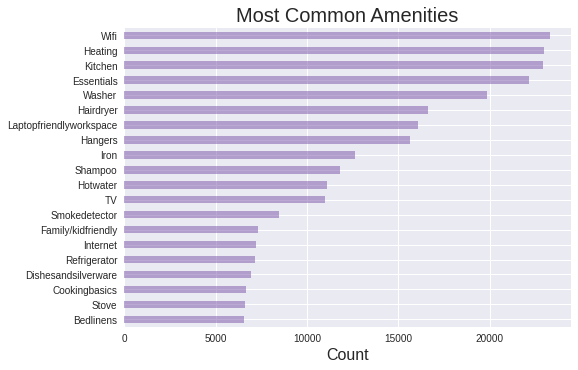

In [36]:
amenit_list= []
for i,row in df.iterrows():
    for amenit in row['amenities'].split('{')[1].split('"'):
        if len(list(amenit)) !=1:
            #amenit = amenit.replace(',',' ')
            #amenit = amenit.replace('"',' ')
            amenit = amenit.replace(' ','')
            amenit = amenit.replace('}','')
            temp_list = amenit.split(',')     
            temp_list = [i for i in temp_list if i]
            #print(temp_list)
            amenit_list.extend(temp_list)
    
amenit_list = pd.DataFrame(amenit_list)
amenit_list.value_counts(ascending=True).tail(20).plot(kind='barh',color='#7953a9', alpha=0.5)



plt.title('Most Common Amenities', fontsize=20);
plt.xlabel('Count', fontsize=16)
plt.ylabel('')

locs, labels =plt.yticks()

for label in labels:
    text =label.get_text()    
    text = text.replace('(','').replace(')','').replace(',','')
    label.set_text(text)
    
plt.yticks(locs,labels);

These are all essentials things, they didn't make me satisfy. Lets remove these common amenities and find out what hosts have more to offer

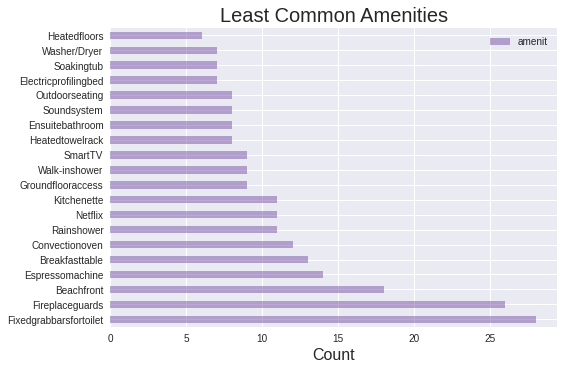

In [37]:
amenit_list= []
for i,row in df.iterrows():
    for amenit in row['amenities'].split('{')[1].split('"'):
        if len(list(amenit)) !=1:
            #amenit = amenit.replace(',',' ')
            #amenit = amenit.replace('"',' ')
            amenit = amenit.replace(' ','')
            amenit = amenit.replace('}','')
            temp_list = amenit.split(',')     
            temp_list = [i for i in temp_list if i]
            #print(temp_list)
            amenit_list.extend(temp_list)
    
amenit_list = pd.DataFrame(amenit_list, columns=['amenit'])

amenit_list =pd.DataFrame(amenit_list.value_counts(), columns=['amenit'])
amenit_list=amenit_list[amenit_list['amenit'] >5]

amenit_list.tail(20).plot(kind='barh',color='#7953a9', alpha=0.5)



plt.title('Least Common Amenities', fontsize=20);
plt.xlabel('Count', fontsize=16)
plt.ylabel('')

locs, labels =plt.yticks()

for label in labels:
    text =label.get_text()    
    text = text.replace('(','').replace(')','').replace(',','')
    label.set_text(text)
    
plt.yticks(locs,labels);

Well, I was expecting a lot more interesting least common things rather than Netflix.


### Berlin's Map and Neighbourhoods
Let's see the distribution of price on Berlin's map.


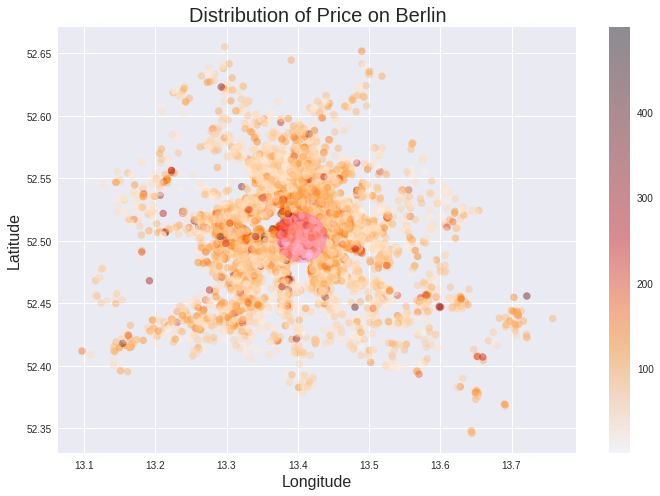

In [38]:
plt.rcParams['figure.figsize'] = [10, 7]

longitude = df['longitude']
latitude = df['latitude']
price = df['price']

fig, ax = plt.subplots()

im = ax.scatter(x=longitude, y=latitude, alpha=0.4,
         c=price, cmap="gist_heat_r");


ax.scatter(x= berlin_long, y=berlin_lat,s=2500, c='magenta', alpha=0.2)



fig.colorbar(im, ax=ax)
ax.set_ylabel('Latitude', fontsize=16)
ax.set_xlabel('Longitude', fontsize=16)
ax.set_title('Distribution of Price on Berlin', fontsize = 20)
fig.tight_layout()

In [39]:
#Get Berlin's Map and it's neighbourhood's coordinates
berlin_boroughs = "https://raw.githubusercontent.com/funkeinteraktiv/Berlin-Geodaten/master/berlin_bezirke.geojson"
berlin_price = df.groupby(by="neighbourhood_group_cleansed").mean().reset_index()
berlin_price = berlin_price.replace('Charlottenburg-Wilm.','Charlottenburg-Wilmersdorf')
berlin_price.neighbourhood_group_cleansed = berlin_price.neighbourhood_group_cleansed.str.replace(' ','')

In [41]:
#Get all neighbourhoods' center points (we will plot on top of our map)
geo_data = pd.read_json('data/berlin_bezirke.geojson')

hood_centers ={}
for i in range(len(geo_data)):
    
    name = geo_data.features[i]['properties']['name']
    coordinates =geo_data.features[i]['geometry']['coordinates']
    coordinates = coordinates[0][0]
    
    longs = []
    lats= []

    for point in coordinates:
        longs.append(point[0])
        lats.append(point[1])

    hood_long = sum(longs)/len(longs)
    hood_lat = sum(lats)/len(lats)
    
    hood_centers[name]= (hood_long,hood_lat)

In [42]:
#Create the map:
berlin_map = folium.Map(location=[berlin_lat, berlin_long], zoom_start=11)
folium.Choropleth(
    geo_data=berlin_boroughs,
    name='choropleth',
    data=berlin_price,
    columns=['neighbourhood_group_cleansed', 'price'],
    key_on='feature.properties.name',
    fill_color="BuPu",
    fill_opacity=0.7,
    line_opacity=1,
    legend_name="Average Price ($)"
).add_to(berlin_map)

#I'm also gonna add a dark theme map, because I can.
folium.TileLayer('cartodbdark_matter').add_to(berlin_map)

folium.LayerControl().add_to(berlin_map)

#Lets add names of neighbourhoods:
markers= []
for hood in hood_centers:
    hood_long = hood_centers[hood][0]
    hood_lat = hood_centers[hood][1]
        
    html =f" <div style='color: white; background-color: brown ;text-align: center;font-family: serif;'>{hood}</div>"
    marker = folium.Marker(title='Mitte',location=[hood_lat,hood_long],
                          icon= folium.DivIcon(icon_size=(100,100),
                                               html=html))

    marker.add_to(berlin_map)

berlin_map

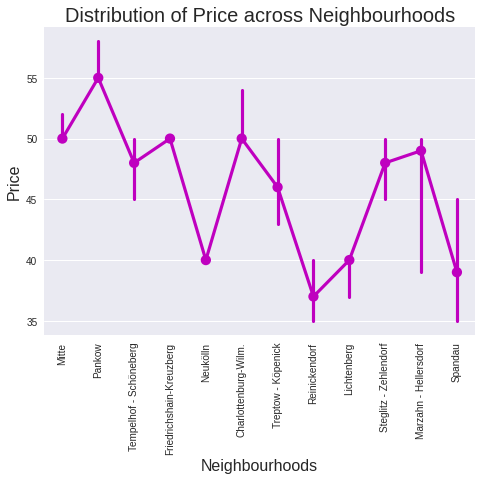

In [43]:
sns.factorplot('neighbourhood_group_cleansed', 'price', data = df, color = 'm',estimator = np.median,aspect=1.35)
xt = plt.xticks(rotation=90)
plt.title('Distribution of Price across Neighbourhoods', fontsize=20)
plt.ylabel('Price', fontsize=16)
plt.xlabel('Neighbourhoods', fontsize=16);

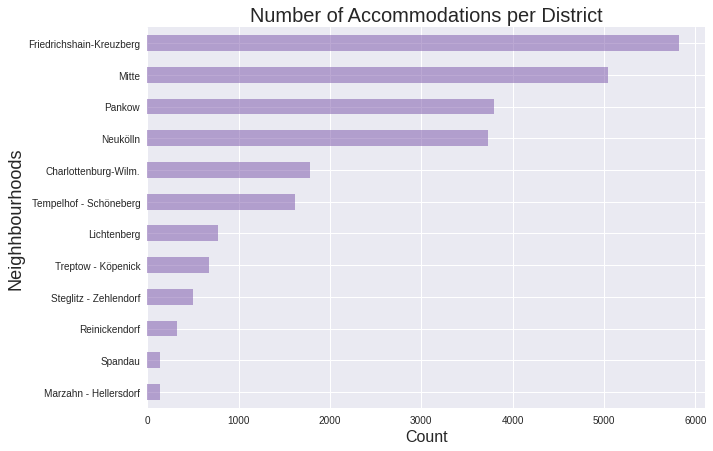

In [44]:
#Number of Accomodations 
df['neighbourhood_group_cleansed'].value_counts().sort_values().plot(kind='barh', color='#7953a9', alpha=0.5)
plt.title('Number of Accommodations per District', fontsize=20);
plt.ylabel('Neighhbourhoods', fontsize=18)
plt.xlabel('Count', fontsize=16);

Well this is suprising, Kreuzberg seems to have the smallest area however have the most airbnb on Berlin. I think this is because of the socio-cultural effect of Kreuzerberg. I know that area is famous with immigrants and also it is in the centre right next to the historical berlin wall.

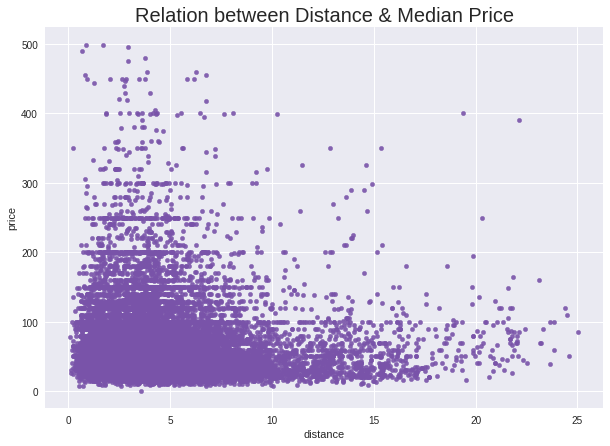

In [45]:
df.plot.scatter(x="distance", y="price", c='#7953a9', alpha=0.9)
plt.title('Relation between Distance & Median Price', fontsize=20);


Text(0.5, 1.0, 'Mean Prices of Properties across Neighbourhoods and Bedroom Counts')

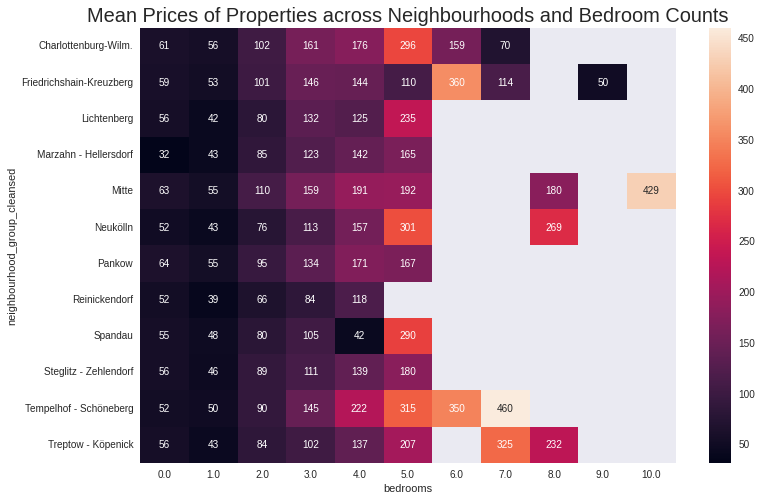

In [46]:
plt.figure(figsize=(12,8))
sns.heatmap(df.groupby([
        'neighbourhood_group_cleansed', 'bedrooms']).price.mean().unstack(),annot=True, fmt=".0f",color ='m');
plt.title('Mean Prices of Properties across Neighbourhoods and Bedroom Counts',fontsize=20)

Text(0.5, 1.0, 'Number of Properties across Neighbourhoods and Bedroom Counts')

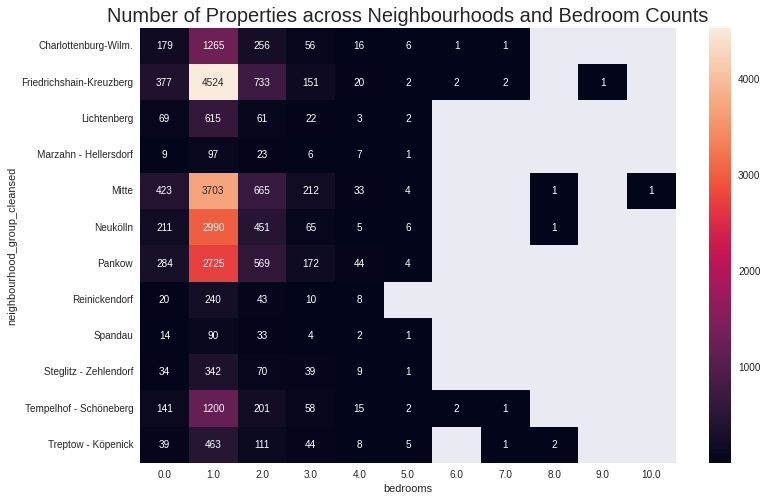

In [47]:
plt.figure(figsize=(12,8))
sns.heatmap(df.groupby([
        'neighbourhood_group_cleansed', 'bedrooms']).bedrooms.count().unstack(),annot=True, fmt=".0f",color ='m');
plt.title('Number of Properties across Neighbourhoods and Bedroom Counts',fontsize=20)

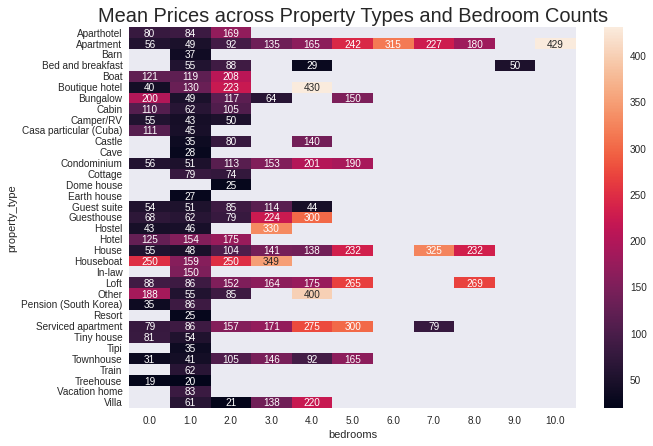

<Figure size 1440x864 with 0 Axes>

In [48]:
sns.heatmap(df.groupby(['property_type', 'bedrooms']).price.mean().unstack(), annot=True, fmt=".0f")
plt.title('Mean Prices across Property Types and Bedroom Counts',fontsize=20)
plt.figure(figsize=(20,12));

## Making the Dataset Ready for Training 

A clean pipeline of my preprocessing and feature engineering

In [49]:
#Import dataset
df_raw = pd.read_csv('data/listings.csv')

#Drop useless columns
df_raw = drop_useless_columns(df_raw)

#Drop text columns for now
df_raw = drop_text_columns(df_raw)

#Drop 51 rows with many nan values
df_raw = df_raw[df_raw['host_since'].isna() == False]

#Categorize columns
df_raw = categorize_host_location(df_raw)
df_raw = categorize_host_neighbourhood(df_raw)
df_raw = categorize_ordinal_columns(df_raw)
df_raw= categorize_columns(col_to_cat,df_raw)
df_raw = amenities_features(df_raw)
df_raw = categorize_amenities(df_raw)

#Replace NaN rows in cleaning_fee and security deposit as 0.
df_raw = replace_nan(df_raw,'cleaning_fee')
df_raw = replace_nan(df_raw,'security_deposit')

#Remove $ sign from price columns
df_raw= convert_prices_into_float(df_raw)

#Remove % sign from host_response_rate
df_raw.host_response_rate = df_raw.host_response_rate.apply(drop_percent)

#Remove abnormal prices
df_raw = df_raw[(df_raw['price'] != 0)]
df_raw = df_raw[(df_raw['price'] < 500)]

#Feature_engineering
df_raw = create_verification_features(df_raw)
df_raw['distance'] = df_raw.apply(lambda x: distance_to_mid(x.latitude, x.longitude), axis=1)

#Drop date columns for now:
df_raw.drop(columns=['host_since','last_scraped','first_review','last_review'],inplace= True)

#Impute Data
#df_raw = impute_df(df_raw)

shape of df: (24551, 80)
26 useless columns are dropped
shape of df: (24551, 68)
12 text columns are dropped


In [50]:
df_raw.shape

(24348, 78)

In [51]:
print_nan_counts(df_raw)

Column Name: NaN Count
-----------------------
space : 8630
host_response_rate : 10366
bathrooms : 29
bedrooms : 19
beds : 29
weekly_price : 21060
monthly_price : 21987
review_scores_rating : 4720
review_scores_accuracy : 4746
review_scores_cleanliness : 4743
review_scores_checkin : 4765
review_scores_communication : 4748
review_scores_location : 4764
review_scores_value : 4767
cancellation_policy : 1
reviews_per_month : 4235


In [52]:
print('Columns with "object" type :')
[ column for column in df_raw.columns if df_raw[column].dtype == object ]

Columns with "object" type :


['space']

In [53]:
#Our data is ready for training
joblib.dump(df_raw,'data/df_processed_2.pkl')

['data/df_processed_2.pkl']